<a href="https://colab.research.google.com/github/nityawastaken/Synapse_LP/blob/week-8/nitya_task_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Task 3**

## **DJS Synapse Learning Period**
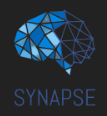

Hello Everyone. Hope you learn and have fun throughout the task!

Now, that we have understood how RNN works, let's dive deeper into LSTM and implement it from scratch.

Refer to the material linked below to understand LSTM in detail.

https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html

https://medium.com/@chunduri11/understanding-lstm-plain-and-simple-96026b4468c6

https://www.youtube.com/watch?v=YCzL96nL7j0&t=1009s&pp=ygUObHN0bSBzdGF0cXVlc3Q%3D

https://medium.com/analytics-vidhya/introduction-to-long-short-term-memory-lstm-a8052cd0d4cd

https://medium.com/@anishnama20/understanding-lstm-architecture-pros-and-cons-and-implementation-3e0cca194094

Load and preprocess the data.

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
##### Data #####
data = """To be, or not to be, that is the question: Whether \
'tis nobler in the mind to suffer The slings and arrows of ou\
trageous fortune, Or to take arms against a sea of troubles A\
nd by opposing end them. To die—to sleep, No more; and by a s\
leep to say we end The heart-ache and the thousand natural sh\
ocks That flesh is heir to: 'tis a consummation Devoutly to b\
e wish'd. To die, to sleep; To sleep, perchance to dream—ay, \
there's the rub: For in that sleep of death what dreams may c\
ome, When we have shuffled off this mortal coil, Must give us\
 pause—there's the respect That makes calamity of so long lif\
e. For who would bear the whips and scorns of time, Th'oppres\
sor's wrong, the proud man's contumely, The pangs of dispriz'\
d love, the law's delay, The insolence of office, and the spu\
rns That patient merit of th'unworthy takes, When he himself \
might his quietus make""".lower()

In [ ]:
chars = set(data)
data_size, char_size = len(data), len(chars)

In [ ]:
print(f'Data size: {data_size}, Char Size: {char_size}')

Data size: 866, Char Size: 32


In [ ]:
char_to_idx = {c:i for i, c in enumerate(chars)}
idx_to_char = {i:c for i, c in enumerate(chars)}

Perform train test split

In [ ]:
#perform train test split here

sequence_length = 32
inputs = []
targets = []
for i in range(0, len(data) - sequence_length, 1):
    inputs.append(data[i:i + sequence_length])
    targets.append(data[i + sequence_length])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

Define onHotEncoding Function

In [ ]:
##### Helper Functions #####
def oneHotEncode(text):
    output = np.zeros((char_size, 1))
    output[char_to_idx[text]] = 1

    return output

Read about Xavier Initialization.

https://cs230.stanford.edu/section/4/

In [ ]:
# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

Define the Activation Functions required.

In [ ]:
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)

    return 1 / (1 + np.exp(-input))

In [ ]:
#similarly define tanh activation function here.
def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2

    return np.tanh(input)

In [ ]:
def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

Now, let's implement LSTM from scratch!

In [ ]:
##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size) ##
        self.bi = np.zeros((hidden_size, 1)) ##

        # Cell states update weights
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final output weights
        self.wy = initWeights(hidden_size, output_size) ##
        self.by = np.zeros((output_size, 1)) ##

     # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))} ##

        self.activation_outputs = {}
        self.cell_updates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.cell_updates[q] =  tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc) ##
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo) ##

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.cell_updates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = np.zeros_like(self.wf), np.zeros_like(self.bf) ##
        d_wi, d_bi = np.zeros_like(self.wi), np.zeros_like(self.bi) ##
        d_wc, d_bc = np.zeros_like(self.wc), np.zeros_like(self.bc) ##
        d_wo, d_bo = np.zeros_like(self.wo), np.zeros_like(self.bo) ##
        d_wy, d_by = np.zeros_like(self.wy), np.zeros_like(self.by) ##

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            #fill this (take forget gate weights and biases errors as reference)
            d_i = d_cs * self.input_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i

            # Cell update weights and errors
            d_c = d_cs * self.input_gates[q] * tanh(self.cell_updates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate ##
        self.bi += d_bi * self.learning_rate ##

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate ##
        self.bo += d_bo * self.learning_rate ##

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate


    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input).reshape(1, -1) for input in inputs]

        for _ in tqdm(range(self.num_epochs)):
            predictions = self.forward(inputs)

            errors = []
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][char_to_idx[labels[q]]] += 1

            self.backward(errors, self.concat_inputs)

 # Test
    def test(self, inputs, labels):
        accuracy = 0
        probabilities = self.forward([oneHotEncode(input).reshape(1, -1) for input in inputs])

        output = ''
        for q in range(len(labels)):
            prediction = idx_to_char[np.random.choice([*range(char_size)], p = softmax(probabilities[q].reshape(-1)))]

            output += prediction

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{"".join(output)}\n')
        print(f'Accuracy: {round(accuracy * 100 / len(inputs), 2)}%')

Hope you understood the implementation! Explain what you understood in detail.

Ans:

In [ ]:
# Initialize Network
hidden_size = 128 ##

lstm = LSTM(input_size = char_size + hidden_size, hidden_size = hidden_size, output_size = char_size, num_epochs = 1_000, learning_rate = 0.05)

##### Training #####
lstm.train(X_train, y_train)

##### Testing #####
# write the code to test the model
lstm.test(X_test, y_test)

KeyError: 'ome, when we have shuffled off t'

**Machine Translation using Encoder-Decoder**

Read about Encoder-Decoder in the links provided below

https://www.youtube.com/watch?v=KiL74WsgxoA&t=292s&pp=ygUcZW5jb2RlciBkZWNvZGVyIGFyY2hpdGVjdHVyZQ%3D%3D

https://www.youtube.com/watch?v=L8HKweZIOmg&pp=ygUcZW5jb2RlciBkZWNvZGVyIGFyY2hpdGVjdHVyZQ%3D%3D

https://medium.com/analytics-vidhya/machine-translation-encoder-decoder-model-7e4867377161

https://medium.com/@anishnama20/exploring-the-power-of-encoder-decoder-models-pros-cons-and-applications-8bfbe2e66e76

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import matplotlib.pyplot as plt
import numpy as np

Download the dataset provided with the task for this implementation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/synapse/week 8 dataset.txt"

In [ ]:
num_samples = 10000

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n" ##
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    #similarly write the code for target_text
    for char in target_text: ##
        if char not in target_characters: ##
            target_characters.add(char) ##

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters)) ##
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters) ##
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts]) ##

In [ ]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)]) ##

In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
) ##!!!!
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space

In [ ]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [ ]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c] ##

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

In [ ]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs) ##

 Define the model that will turn
 `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

In [ ]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
#train the model
model.compile(
    #implement appropriate optimizer, loss and accuracy
    optimizer="rmsprop", ##
    loss="categorical_crossentropy", ##
    metrics=["accuracy"], ##
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("model.keras")

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7054 - loss: 1.5471 - val_accuracy: 0.7141 - val_loss: 1.3305
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7471 - loss: 0.9652 - val_accuracy: 0.7193 - val_loss: 0.9832
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7627 - loss: 0.8644 - val_accuracy: 0.7397 - val_loss: 0.8843
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7836 - loss: 0.7765 - val_accuracy: 0.7714 - val_loss: 0.7989
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8030 - loss: 0.6880 - val_accuracy: 0.7882 - val_loss: 0.7328
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8153 - loss: 0.6413 - val_accuracy: 0.8023 - val_loss: 0.6932
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8219 - loss: 0.6140 - val_accuracy: 0.8078 - val_loss: 0.6615
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8290 - loss: 0.5826 - 

In [ ]:
model = keras.models.load_model("model.keras")

In [ ]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [ ]:
decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,)) ##
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec] ##
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Run the cell below and explain here in detail how the cell works.

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Continuez.

-
Input sentence: Go.
Decoded sentence: Continuez.

-
Input sentence: Go.
Decoded sentence: Continuez.

-
Input sentence: Go.
Decoded sentence: Continuez.

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded 

**Bonus Task**

Exploring Bidirectional RNNs and the BiLSTM Architecture

Implementing a BiLSTM model for a specific NLP task (e.g., named entity recognition or sentiment analysis)